In [3]:
import sys
import re
import time
import datetime
import pandas as pd
import numpy as np
import func
# inline plot
import matplotlib.pyplot as plt
%matplotlib inline

/Users/albarron/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
df = pd.read_csv("data/merged_concat_final.csv",sep='\t',error_bad_lines=False)
del df['Unnamed: 0']
print df.shape

(21021, 33)


In [5]:
df.columns.values

array(['train_id', 'stop_pa', 't_northbound', 'timestamp', 'temp',
       'precipiation', 'visability', 'windspeed', 'humidity', 'cloudcover',
       'is_bullet', 'is_limited', 'tweet_id', 'is_delay', 'del_min',
       'del_med', 'del_maj', 'del_cat', 'is_backlog', 'is_canceled',
       'is_passing', 'is_accident', 'is_medical', 'is_mechanical',
       'is_customer', 'is_event', 'd_monday', 'd_tuesday', 'd_wednesday',
       'd_thursday', 'd_friday', 'd_saturday', 'd_sunday'], dtype=object)

In [6]:
df[['del_min','del_med','del_maj','del_cat']].sum()

del_min     91
del_med    142
del_maj     28
del_cat     16
dtype: int64

In [7]:
df.set_index('timestamp')
df['timestamp'] = pd.to_datetime(df['timestamp'],format="%Y-%m-%d %H:%M:%S")

In [8]:
def delay_to_ordinal(r):
    v = 0 #no delay
    v = 1 if r['del_min'] == 1 else v
    v = 2 if r['del_med'] == 1 else v
    v = 3 if r['del_maj'] == 1 else v
    v = 4 if r['del_cat'] == 1 else v
    return v

df['ord_del'] = df.apply(lambda x:delay_to_ordinal(x),axis=1)

In [9]:
def days_to_ordinal(r):
    v = 0 # Sunday
    v = 1 if r['d_monday'] == 1 else v
    v = 2 if r['d_tuesday'] == 1 else v
    v = 3 if r['d_wednesday'] == 1 else v
    v = 4 if r['d_thursday'] == 1 else v
    v = 5 if r['d_friday'] == 1 else v
    v = 5 if r['d_saturday'] == 1 else v
    return v

df['ord_weekdays'] = df.apply(lambda x:days_to_ordinal(x),axis=1)

In [10]:
only_delay = df[(df['is_delay']==1)]

In [ ]:
# df.plot.scatter(x=df['timestamp'],y=df['ord_del'],figsize=[15,6], alpha='0.2')

In [ ]:
# only_delay[['del_min','del_med','del_maj','del_cat','is_bullet','is_limited']].plot.hist(color='k',alpha=0.5,stacked=True,bins=4,figsize=[12,6])

In [11]:
print "relative to delay"
print (df[['is_delay','del_min','del_med','del_maj','del_cat']].sum()/float(df['is_delay'].sum()))*100 , '%'
print "Relative to total"
print (df[['is_delay','del_min','del_med','del_maj','del_cat']].sum()/float(len(df)))*100 , '%'

relative to delay
is_delay    100.000000
del_min      27.828746
del_med      43.425076
del_maj       8.562691
del_cat       4.892966
dtype: float64 %
Relative to total
is_delay    1.555587
del_min     0.432900
del_med     0.675515
del_maj     0.133200
del_cat     0.076114
dtype: float64 %


In [48]:
# Train IDs swapped into cat variables and concat into main dataset
train_id_dummies = pd.get_dummies(df['train_id'],prefix='tid')
train_id_dummies.shape
train_id_dummies.columns.values
del train_id_dummies['tid_101.0'] # Delete as base var
tid_col = train_id_dummies.columns.values
df = pd.concat([df, train_id_dummies], axis=1)

### Pick one of these to explore re: below models

In [ ]:
# Look only at train IDs
features = df.columns.values
X = train_id_dummies
y = df['ord_del']

In [55]:
# Non Delay Specific
features = df.columns.values
target_cols = ['temp','precipiation',
        'visability','windspeed','humidity','cloudcover',
        'is_bullet','is_limited','t_northbound',
       'd_monday','d_tuesday','d_wednesday','d_thursday','d_friday','d_saturday']
X = df[target_cols]
# del X['is_delay']
# del X['tweet_id']
# X['timestamp'] = X['timestamp'].apply(lambda x: (np.datetime64(x).astype('uint64') / 1e6).astype('uint32'))
# y = df['ord_del']
y = df['is_delay']

In [ ]:
# Including train IDs
features = df.columns.values
target_cols = ['temp','precipiation',
        'visability','windspeed','humidity','cloudcover',
        'is_bullet','is_limited','t_northbound',
       'd_monday','d_tuesday','d_wednesday','d_thursday','d_friday','d_saturday'] + list(tid_col)
X = df[target_cols]
# del X['is_delay']
# del X['tweet_id']
# X['timestamp'] = X['timestamp'].apply(lambda x: (np.datetime64(x).astype('uint64') / 1e6).astype('uint32'))
# y = df['ord_del']
y = df['is_delay']

In [ ]:
# If there IS a delay...
features = df.columns.values
X = only_delay[['is_backlog', 'is_canceled',
       'is_passing', 'is_accident', 'is_medical', 'is_mechanical',
       'is_customer', 'is_event']]
# del X['is_delay']
# del X['tweet_id']
# X['timestamp'] = X['timestamp'].apply(lambda x: (np.datetime64(x).astype('uint64') / 1e6).astype('uint32'))
y = df['ord_del']

In [58]:
# X['timestamp'] = X['timestamp'].apply(lambda x:int(x))
# X['stop_pa'] = X['stop_pa'].apply(lambda x:int(x))
# X['train_id'] = X['train_id'].apply(lambda x:int(x))
X['t_northbound'] = X['t_northbound'].apply(lambda x:int(x))

/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [59]:
X['cloudcover'] = X['cloudcover'].fillna(X['cloudcover'].mean())

/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [68]:
# X.isnull().sum()

In [ ]:
# df.plot.scatter(x='timestamp',y='del_ord',figsize=[15,5])

In [ ]:
X_y = only_delay[['is_delay','ord_del','temp','precipiation',
        'visability','windspeed','humidity','cloudcover',
        'is_bullet','is_limited','t_northbound',
       'd_monday','d_tuesday','d_wednesday','d_thursday','d_friday','d_saturday']]
cr = X_y.corr()
np.round(cr, 4)
# 

In [ ]:
X_y.sum()

### Run Decision Trees, Prune, and consider False Positives

In [61]:
from sklearn.tree import DecisionTreeClassifier
TreeClass = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)
TreeClass.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [62]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(TreeClass, X, y, cv=10)
print(scores.mean()) # Score = More is better, error is 1-score

0.992055614405


In [70]:
from sklearn.metrics import confusion_matrix
y_hat = TreeClass.predict(X)
cmat = confusion_matrix(y, y_hat)
print cmat

[[20648    46]
 [  121   206]]


In [64]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
y_hat_probability = TreeClass.predict_proba(X).T[1] 
print(y_hat_probability)
print(roc_auc_score(y, y_hat_probability))
vals = roc_curve(y, y_hat_probability)  

[ 0.00582599  0.00582599  0.00582599 ...,  0.00582599  0.00582599
  0.00582599]
0.813990833077


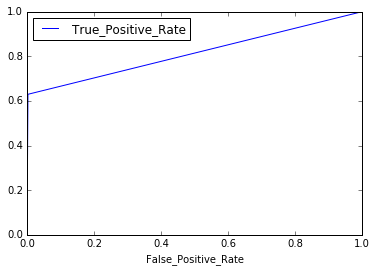

In [65]:
Roc_DataFrame = pd.DataFrame({'False_Positive_Rate':vals[0],'True_Positive_Rate':vals[1]})
Roc_DataFrame.plot(x = 'False_Positive_Rate' , y = 'True_Positive_Rate' ) 

### As a check, consider Feature selection

In [19]:
from sklearn import feature_selection
pvals = feature_selection.f_regression(X,y)[1] 
sorted(zip(X.columns.values,np.round(pvals,4)),key=lambda x:x[1],reverse=True)

[('d_friday', 0.36280000000000001),
 ('windspeed', 0.34889999999999999),
 ('t_northbound', 0.15679999999999999),
 ('precipiation', 0.1358),
 ('humidity', 0.048800000000000003),
 ('cloudcover', 0.0465),
 ('d_saturday', 0.0047999999999999996),
 ('visability', 0.0016000000000000001),
 ('d_monday', 0.001),
 ('d_tuesday', 0.0001),
 ('temp', 0.0),
 ('is_bullet', 0.0),
 ('is_limited', 0.0),
 ('d_wednesday', 0.0),
 ('d_thursday', 0.0)]

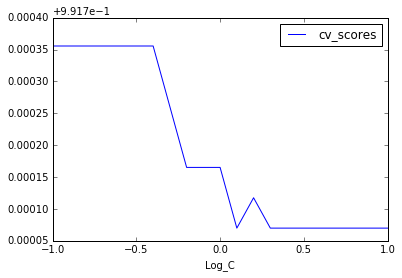

In [45]:
X_lr=df[['windspeed','t_northbound','precipiation','d_friday']]
# localize your search around the maximum value you found
c_list = np.logspace(-1,1,21) 
c_index = np.linspace(-1,1,21)
#C is just the inverse of Lambda - the smaller the C - the stronger the
#regulatization. The smaller C's choose less variables
cv_scores = []
for c_score in c_list:
    lm = LogisticRegression(C = c_score, penalty = "l1")
    cv_scores.append(cross_val_score(lm,X,y,cv=10).mean())


C_Choice_df = pd.DataFrame({'cv_scores': cv_scores ,'Log_C': c_index })
C_Choice_df.plot(x ='Log_C',y = 'cv_scores' )
# it sounds like our best choice is C = -0.1  (we chose the most restrictive option)

### Find the Principal Components

In [ ]:
X = only_delay[['temp','precipiation',
        'visability','windspeed','humidity','cloudcover',
        'is_bullet','is_limited','t_northbound',
       'd_monday','d_tuesday','d_wednesday','d_thursday','d_friday','d_saturday']]

In [20]:
from sklearn.decomposition import PCA
clf = PCA(.99)
X_trans = clf.fit_transform(X)
X_trans.shape

(21021, 4)

In [27]:
print "Exp Var ratio:",clf.explained_variance_ratio_
print "PCA Score:",clf.score(X,y)

Exp Var ratio: [ 0.94377417  0.03863902  0.00479571  0.00322025]
PCA Score: -7.97024397141


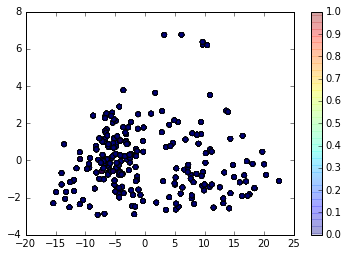

In [21]:

plt.scatter(X_trans[:, 0], X_trans[:, 1],c=y, alpha=0.2)
plt.colorbar();

In [28]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
lm.fit(X_trans,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [29]:
print(lm.intercept_)
print(lm.coef_)

[-4.22049215]
[[-0.04419672 -0.04835333  0.31824815 -0.15575732]]


In [30]:
from sklearn.cross_validation import cross_val_score
print(cross_val_score(lm,X_trans,y,cv=10).mean()) 
MisClassificationError = 1 - (cross_val_score(lm,X_trans,y,cv=10).mean())
print(MisClassificationError)

0.984444199569
0.0155558004307


### Seeing if I can get anything interesting out of KNN given above

# Lecture 10, look at Confusion matrix and ROC curve. Fiddle with the thresholds and AUC

In [31]:
print df['windspeed'].max()
print df['windspeed'].min()

12.5654166667
2.63625


In [32]:
df['windspeed_st'] = df['windspeed'].apply(lambda x:x/15.0) # Ballparking 

In [33]:

X_reg = df[['precipiation','d_friday','t_northbound','windspeed_st']]
y_reg = df['is_delay']

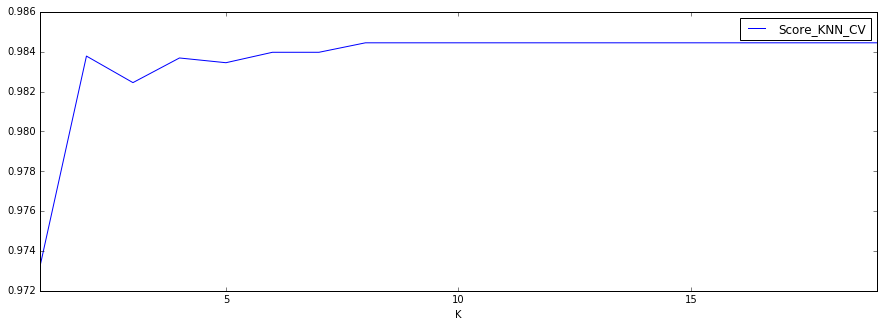

In [34]:
from sklearn import cross_validation
from sklearn import neighbors, metrics
kf = cross_validation.KFold(len(X_reg), n_folds = 10, shuffle = True) #10 fold CV
Score_KNN_CV = []
RangeOfK = range(1,20) 
scores = []
for k in RangeOfK:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')
    scores = []
    for train_index, test_index in kf:        
        knn.fit(X_reg.iloc[train_index], y_reg.iloc[train_index])
        scores.append(knn.score(X_reg.iloc[test_index],y_reg.iloc[test_index]))
    Score_KNN_CV.append(np.mean(scores))

Score_KNN_CV_df = pd.DataFrame({'Score_KNN_CV': Score_KNN_CV ,'K': RangeOfK })
Score_KNN_CV_df.plot(x = 'K',y = 'Score_KNN_CV',figsize=[15,5])

### Cross Validation and Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
RFClass = RandomForestClassifier(n_estimators = 10000, 
                                 max_features = 4, # You can set it to a number or 'sqrt', 'log2', etc
                                 min_samples_leaf = 5,
                                 oob_score = True)
RFClass.fit(X,y)
print(RFClass.oob_score_)
scores = cross_val_score(RFClass, X, y, cv=10)
print(scores.mean())
#out of bag error = 25% , CV_error is 35%

In [ ]:
RFClass.fit(X,y)
ImportanceDataFrame = pd.DataFrame({'feature':X.columns.values, 'importance':RFClass.feature_importances_})
ImportanceDataFrame.sort_values(by = ['importance'],ascending = 0)

In [ ]:
Depth_Choice_df = pd.DataFrame({'cv_scores': score,'Number of Features': Features})
Depth_Choice_df.plot(x ='Number of Features',y = 'cv_scores')